In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
len(test_df)

input\sample_submission.csv
input\test.csv
input\train.csv


4277

### Libraries

Below is all the libraries necessary to run the code.

In [3]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

ImportError: cannot import name 'xgb' from 'xgboost' (C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\xgboost\__init__.py)

In [ ]:
# Hello Ledile

def get_categorical_variables(df):
    return df.select_dtypes(include=['object']).columns

c_var=get_categorical_variables(train_df)


NameError: name 'X' is not defined

# Exploratory Data Analysis

Exploratory data analysis (EDA) is performed on the datasat to investigate features. 

### Features

First, the data is presented using the head() function to show what features exist within the data.

In [17]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


The current features of the dataset are each described below.
* PassengerID - in form gggg_pp. gggg represents the group the passenger is travelling in and pp represents the person number within the group
* HomePlanet - Passenger's planet of residence
* CryoSleep - Bool value for if passenger is in cryosleep
* Cabin - which cabin they have booked on the spaceship
* Destination - where the passenger is going
* Age - the age of the passenger
* VIP - Bool value if passenger is a VIP
* RoomService - amount of credits passenger has spent on room service
* FoodCourt - amount of credits passenger has spent at the food court
* ShoppingMall - amount of credits passenger has spent at the mall
* Spa - amount of credits passenger has spent
* VRDeck - amount of credits passenger has spent at VR Deck
* Name - passenger's name
* Transported - If the patient was transported to another dimension. This is the target variable that the model will need to predict.

The target feature which the models will predict is the 'Transported' feature. This feature shows wether or not a passenger was transported. Firstly the target feature is plot as pie chart to illustrate the distrubtion of passengers that were transported or not.

Text(0.5, 1.0, 'Target distribution')

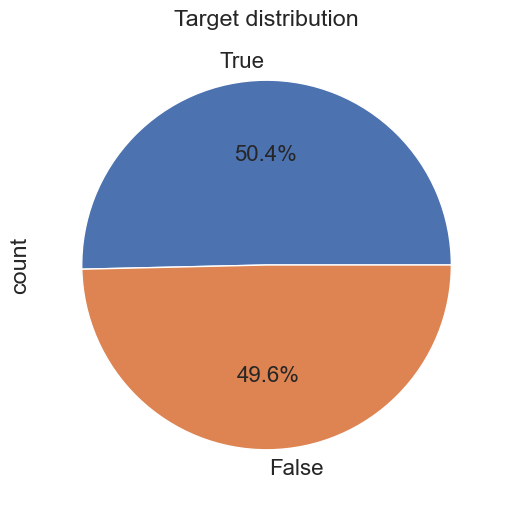

In [12]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, textprops={'fontsize':16}).set_title("Target distribution")

The pie shart shows the target is evenly balanced between true and false.

### Missing Values

Before looking deeper into each feature of the data, its important to check for any missing variables within the dataset. These missing variable will be handled after performing the data analysis.

In [19]:
# The isna() function check if there are any missing or null values within cells of a column.
print('TRAIN SET MISSING VALUES:')
print(train_df.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test_df.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


## Function: hyperparameter_tuning

This function performs hyperparameter tuning for a given model using either GridSearchCV or RandomizedSearchCV from scikit-learn.

### Parameters:
- `model`: Scikit-learn estimator object.
- `param_grid` (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter values to try.
- `X_train` (array-like): Feature matrix of training data.
- `y_train` (array-like): Target vector of training data.
- `cv` (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy. Default is 5-fold cross-validation.
- `search_type` (str): Type of hyperparameter search, either 'grid' for GridSearchCV or 'random' for RandomizedSearchCV. Default is 'grid'.

### Returns:
- `best_estimator`: Fitted model with the best hyperparameters found during the search.

### Example Usage:
```python
from sklearn.svm import SVC

# Define parameter grid for SVC
svc_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'kernel': ['linear', 'rbf']}

# Perform hyperparameter tuning for SVC
best_svc = hyperparameter_tuning(SVC(), svc_param_grid, X_train, y_train)


In [1]:

def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, search_type='grid'): 
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    else:
        raise ValueError("Invalid search_type. Choose either 'grid' or 'random'.")

    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_
    
    return best_estimator


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def apply_ml_model(model, X, y, test_size=0.2, random_state=None):
    """
    Apply a machine learning model on the given data and calculate accuracy.

    Parameters:
        model: The machine learning model to be applied.
        X: The features of the dataset.
        y: The target variable of the dataset.
        test_size: The proportion of the dataset to include in the test split.
        random_state: Random seed for reproducibility.

    Returns:
        accuracy: Accuracy of the model on the test set.
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Load your data here
# Assuming you have features in X and target variable in y

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=SEED)

# Apply Random Forest model
rf_accuracy = apply_ml_model(rf_model, X, y)
print("Random Forest Accuracy:", rf_accuracy)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=SEED)

# Apply XGBoost model
xgb_accuracy = apply_ml_model(xgb_model, X, y)
print("XGBoost Accuracy:", xgb_accuracy)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Define Logistic Regression model
logreg_model = LogisticRegression()

# Apply Logistic Regression model
logreg_accuracy = apply_ml_model(logreg_model, X, y)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Define K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Apply K-Nearest Neighbors model
knn_accuracy = apply_ml_model(knn_model, X, y)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
from sklearn.naive_bayes import GaussianNB

# Define Naive Bayes model
nb_model = GaussianNB()

# Apply Naive Bayes model
nb_accuracy = apply_ml_model(nb_model, X, y)
print("Naive Bayes Accuracy:", nb_accuracy)
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the Linear SVC model
linear_svc_model = LinearSVC()

# Perform GridSearchCV
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2']}
grid_search_svc = GridSearchCV(linear_svc_model, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

# Get the best parameters and create the best model
best_linear_svc = LinearSVC(**grid_search_svc.best_params_)

# Evaluate the best Linear SVC model
svc_accuracy = apply_ml_model(best_linear_svc, X, y)
print("Linear SVC Accuracy:", svc_accuracy)

# Define the LGBMClassifier model
lgbm_model = LGBMClassifier(learning_rate=0.05, random_state=42, max_depth=12, num_leaves=31, n_estimators=100)

# Fit and evaluate the LGBMClassifier model
lgbm_accuracy = apply_ml_model(lgbm_model, X, y)
print("LGBMClassifier Accuracy:", lgbm_accuracy)
